In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from keras.models import Sequential, Model, Input
from keras.layers import Dense


Using TensorFlow backend.


In [2]:
df = pd.read_csv("/datc/opschaler/combined_gas_smart_weather_dfs/processed/all_dwellings_combined_hour.csv",delimiter="\t", parse_dates = ['datetime'])

df = df.set_index(['datetime'])
#making the gaspower more readable (scaling)
df['gasPower'] = df['gasPower']*10



# Quick EDA

In [3]:
#creating correlation matrix function
def corr_matrix (data):

    #initialising correlations
    corr = data.corr()

    #creating a mask for corr matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    return sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})



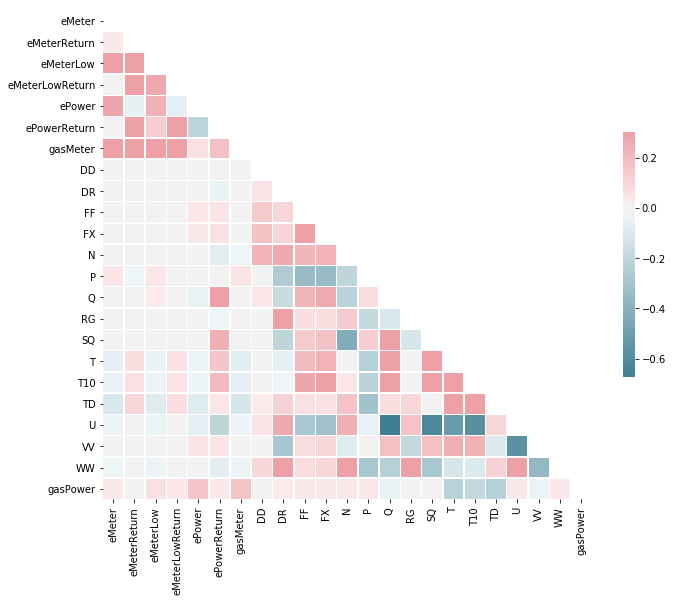

In [4]:
corr_matrix(df)

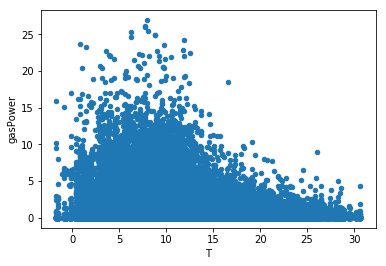

In [5]:
#quick scatter
df.plot(kind='scatter', x='T',y='gasPower')

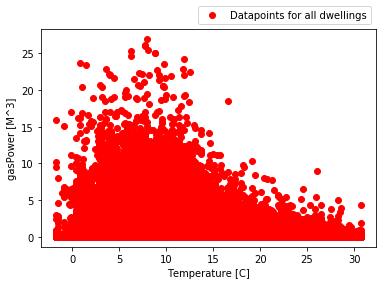

In [6]:
#quick scatter using matplotlib
#setting variables
x_data = df['T']
y_data = df['gasPower']

plt.plot(x_data,y_data,'o', color='r')
plt.xlabel('Temperature [C]')
plt.ylabel('gasPower [M^3]')
plt.legend(['Datapoints for all dwellings'], bbox_to_anchor=(1,1), loc=4)
plt.show()

# Creating extra (possibly) useful features for MVLR

In [7]:
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,RG,SQ,T,T10,TD,U,VV,WW,dwelling,gasPower
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-07 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,307.44101,305.450012,0.0,5.341667,...,0.0,7.631617,8.733334,9.133333,4.883333,76.500000,31916.666016,1.333333,P01S01W7548,NaN
2017-03-07 16:00:00,625.401001,0.0,359.501007,0.0,383.994446,0.0,307.44101,288.200012,0.0,5.418334,...,0.0,10.000000,9.116667,10.750000,5.416667,77.166664,23800.000000,2.666667,P01S01W7548,0.0
2017-03-07 17:00:00,625.679993,0.0,359.501007,0.0,277.722229,0.0,307.44101,285.866669,0.0,4.593333,...,0.0,2.936100,7.866667,8.450000,4.550000,78.833336,22233.333984,1.000000,P01S01W7548,0.0
2017-03-07 18:00:00,625.820984,0.0,359.501007,0.0,143.624283,0.0,307.44101,286.633331,0.0,3.783333,...,0.0,5.000000,7.066667,6.816667,4.433333,82.833336,20266.666016,2.500000,P01S01W7548,0.0
2017-03-07 19:00:00,625.963013,0.0,359.501007,0.0,143.376038,0.0,307.44101,278.783325,0.0,2.741667,...,0.0,0.000000,6.616667,6.016667,4.300000,84.666664,17433.333984,2.833333,P01S01W7548,0.0


In [8]:
#Jeroen suggested using dummyvariables, so that's what's created here. Making a T-1 and hour of day/ day of week variables

#T-1
def dummies(df):
    df['T-1'] = df['T'].shift(1)

    #Creating hour of the day and day of the week variables
    df['hour'] = df.index.hour #creating a column that takes the hour of the day from the DateTime index
    df['dayofweek'] = df.index.dayofweek #same but with the day of the week, obviously

    #Creating dummyvariables out of the columns above (meaning making a ones-matrix from the columns)
    add_columns = ['hour', 'dayofweek'] #making variable for the columns
    df[add_columns] = df[add_columns].astype('category') #in order to make dummy variables, they need to be of the type category
    df = pd.get_dummies(df, columns=add_columns)
    return df

df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,RG,SQ,T,T10,TD,U,VV,WW,dwelling,gasPower
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-07 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,307.44101,305.450012,0.0,5.341667,...,0.0,7.631617,8.733334,9.133333,4.883333,76.500000,31916.666016,1.333333,P01S01W7548,NaN
2017-03-07 16:00:00,625.401001,0.0,359.501007,0.0,383.994446,0.0,307.44101,288.200012,0.0,5.418334,...,0.0,10.000000,9.116667,10.750000,5.416667,77.166664,23800.000000,2.666667,P01S01W7548,0.0
2017-03-07 17:00:00,625.679993,0.0,359.501007,0.0,277.722229,0.0,307.44101,285.866669,0.0,4.593333,...,0.0,2.936100,7.866667,8.450000,4.550000,78.833336,22233.333984,1.000000,P01S01W7548,0.0
2017-03-07 18:00:00,625.820984,0.0,359.501007,0.0,143.624283,0.0,307.44101,286.633331,0.0,3.783333,...,0.0,5.000000,7.066667,6.816667,4.433333,82.833336,20266.666016,2.500000,P01S01W7548,0.0
2017-03-07 19:00:00,625.963013,0.0,359.501007,0.0,143.376038,0.0,307.44101,278.783325,0.0,2.741667,...,0.0,0.000000,6.616667,6.016667,4.300000,84.666664,17433.333984,2.833333,P01S01W7548,0.0


In [9]:
#making a distinction between hourly and daily data
df_h = df
df = df_h.resample('D').mean()

#checking if dummies still work properly
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,Q,RG,SQ,T,T10,TD,U,VV,WW,gasPower
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-22,1438.456541,0.0,1667.423814,0.0,172.213024,0.0,1678.402532,243.553846,410.153846,8.478718,...,36.371795,1.026923,0.000000,9.315385,9.052564,8.276923,92.807692,10240.384615,50.064102,2.562459
2017-02-23,1558.435883,0.0,1805.226395,0.0,173.374907,0.0,1685.894847,239.148194,265.916667,11.608438,...,24.312500,0.461319,0.149737,8.590000,8.163889,6.441597,86.511805,12887.305430,41.759722,4.857127
2017-02-24,1561.837229,0.0,1806.231979,0.0,246.992340,0.0,1694.890589,278.093543,45.766667,5.032826,...,107.562499,0.054306,2.962413,4.746250,3.968194,2.241736,83.740972,28850.902303,13.997222,2.768300
2017-02-25,1564.963013,0.0,1808.506632,0.0,150.144606,0.0,1698.313894,202.265418,14.750000,6.502271,...,49.312501,0.002083,0.361316,5.606806,4.653194,2.398264,79.870832,28918.541423,9.211111,0.171661
2017-02-26,1564.963013,0.0,1817.410950,0.0,679.171475,0.0,1706.148254,208.350207,82.633334,7.540049,...,24.770834,0.098611,0.039483,8.688750,8.264306,6.636181,86.559028,20726.805461,17.117361,5.030009


In [10]:
df_h = dummies(df_h)
df_h = df_h.dropna()
df_h.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,hour_21,hour_22,hour_23,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-07 16:00:00,625.401001,0.0,359.501007,0.0,383.994446,0.0,307.441010,288.200012,0.0,5.418334,...,0,0,0,0,1,0,0,0,0,0
2017-03-07 17:00:00,625.679993,0.0,359.501007,0.0,277.722229,0.0,307.441010,285.866669,0.0,4.593333,...,0,0,0,0,1,0,0,0,0,0
2017-03-07 18:00:00,625.820984,0.0,359.501007,0.0,143.624283,0.0,307.441010,286.633331,0.0,3.783333,...,0,0,0,0,1,0,0,0,0,0
2017-03-07 19:00:00,625.963013,0.0,359.501007,0.0,143.376038,0.0,307.441010,278.783325,0.0,2.741667,...,0,0,0,0,1,0,0,0,0,0
2017-03-07 20:00:00,626.458984,0.0,359.501007,0.0,499.144440,0.0,307.544006,245.816666,0.0,3.418333,...,0,0,0,0,1,0,0,0,0,0


In [11]:
df = dummies(df)
df = df.dropna()
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,gasPower,T-1,hour_0,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-23,1558.435883,0.0,1805.226395,0.0,173.374907,0.0,1685.894847,239.148194,265.916667,11.608438,...,4.857127,9.315385,1,0,0,0,1,0,0,0
2017-02-24,1561.837229,0.0,1806.231979,0.0,246.992340,0.0,1694.890589,278.093543,45.766667,5.032826,...,2.768300,8.590000,1,0,0,0,0,1,0,0
2017-02-25,1564.963013,0.0,1808.506632,0.0,150.144606,0.0,1698.313894,202.265418,14.750000,6.502271,...,0.171661,4.746250,1,0,0,0,0,0,1,0
2017-02-26,1564.963013,0.0,1817.410950,0.0,679.171475,0.0,1706.148254,208.350207,82.633334,7.540049,...,5.030009,5.606806,1,0,0,0,0,0,0,1
2017-02-27,1566.147619,0.0,1828.823593,0.0,253.032893,0.0,1711.548060,192.541318,111.916667,7.891396,...,1.315816,8.688750,1,1,0,0,0,0,0,0


# Creating LR model hourly


In [22]:
#specifying independant and dependant variables for hourly and daily, and for LR and MVR
X_LR_h = df_h[['T']]
X_MVR_h = df_h[['T','T-1','dayofweek_0','dayofweek_1','dayofweek_2','dayofweek_3','dayofweek_4','dayofweek_5','dayofweek_6']]

X_LR = df[['T']]
X_MVR = df[['T','T-1','dayofweek_0','dayofweek_1','dayofweek_2','dayofweek_3','dayofweek_4','dayofweek_5','dayofweek_6']]

y_h = df_h[['gasPower']]
y = df[['gasPower']]

def MVR(df,x,y,test_size,sample_rate='DAILY'): #sample_rate = string in all caps
    #x = np.array(x).reshape(-1,1)
    y = np.array(y)#.reshape(-1,1)

    #the index at which to split df into train and test
    split_index = int(df.shape[0]*test_size) 

    X_train = x[:split_index]
    y_train = y[:split_index]


    X_test = x[split_index:]
    y_test = y[split_index:]

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    #Getting the datetimes for the splits
    X_datetime=df.index[:len(X_train)]
    X1_datetime=df.index[len(X_train):]

    #predict actual values
    Y_prediction=model.predict(X_test)

    # %matplotlib notebook
    %matplotlib inline
    plt.figure(figsize=(20,11))
    plt.plot(X1_datetime,y_test,'.-',alpha=0.4,color='r',label='TEST DATA')
    plt.plot(X1_datetime,Y_prediction,'.-',alpha=0.7,color='b',label='PREDICTED DATA')     
    

    plt.grid(True)
    plt.title('1 '+sample_rate+' PREDICTION \n T,T-1, DAY OF THE WEEK \nMSE: '+ str(mean_squared_error(y_test,Y_prediction)))
    plt.xlabel( 'Datetime')
    plt.xticks(rotation='vertical' )
    plt.ylabel('gasPower [m$^3$ per hour]')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    return plt.show()


# LR on daily sample rate

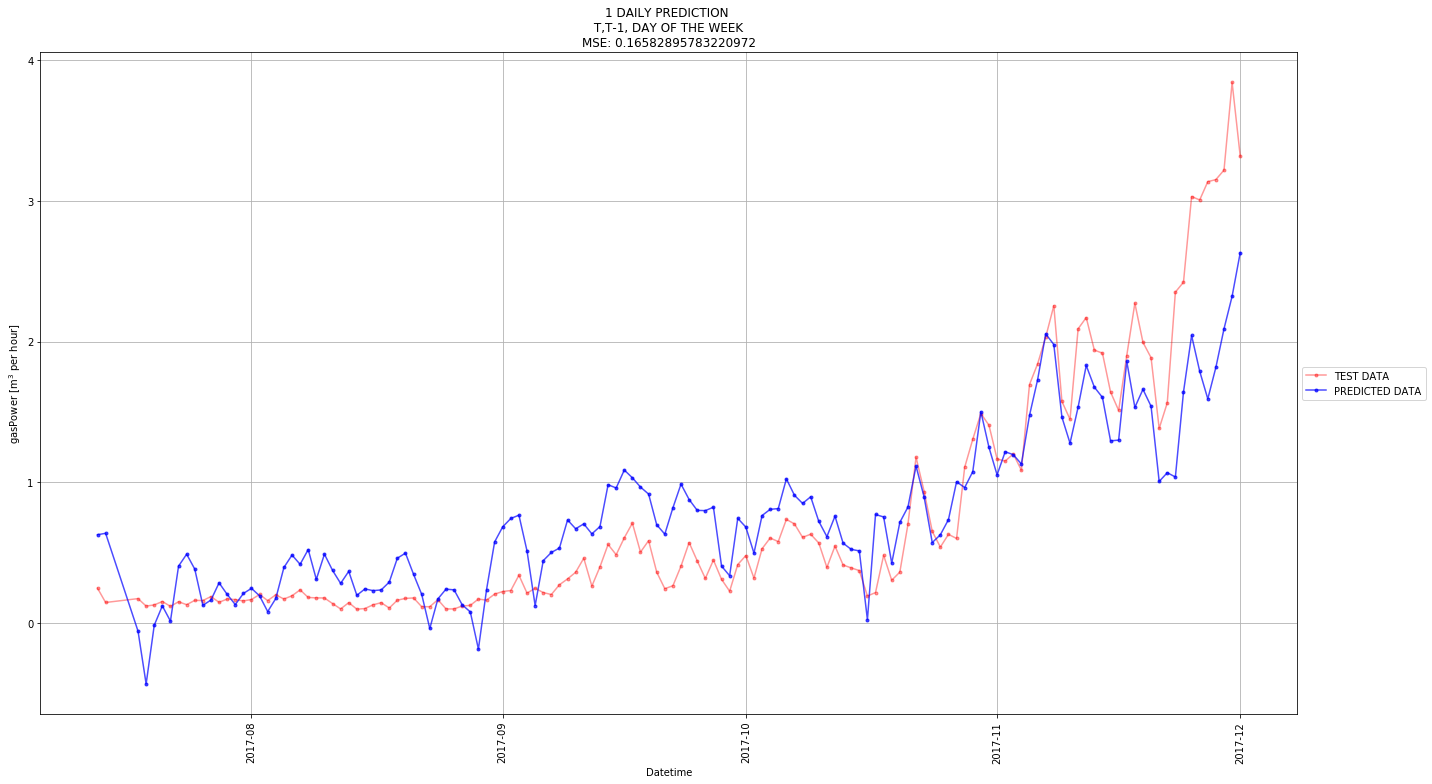

<Figure size 432x288 with 0 Axes>

In [24]:
MVR(df,X_LR,y,0.5)

plt.savefig('MVR result daily[T,T-1,dayofweek].png', dpi=1200)

# MVR of daily sample rate

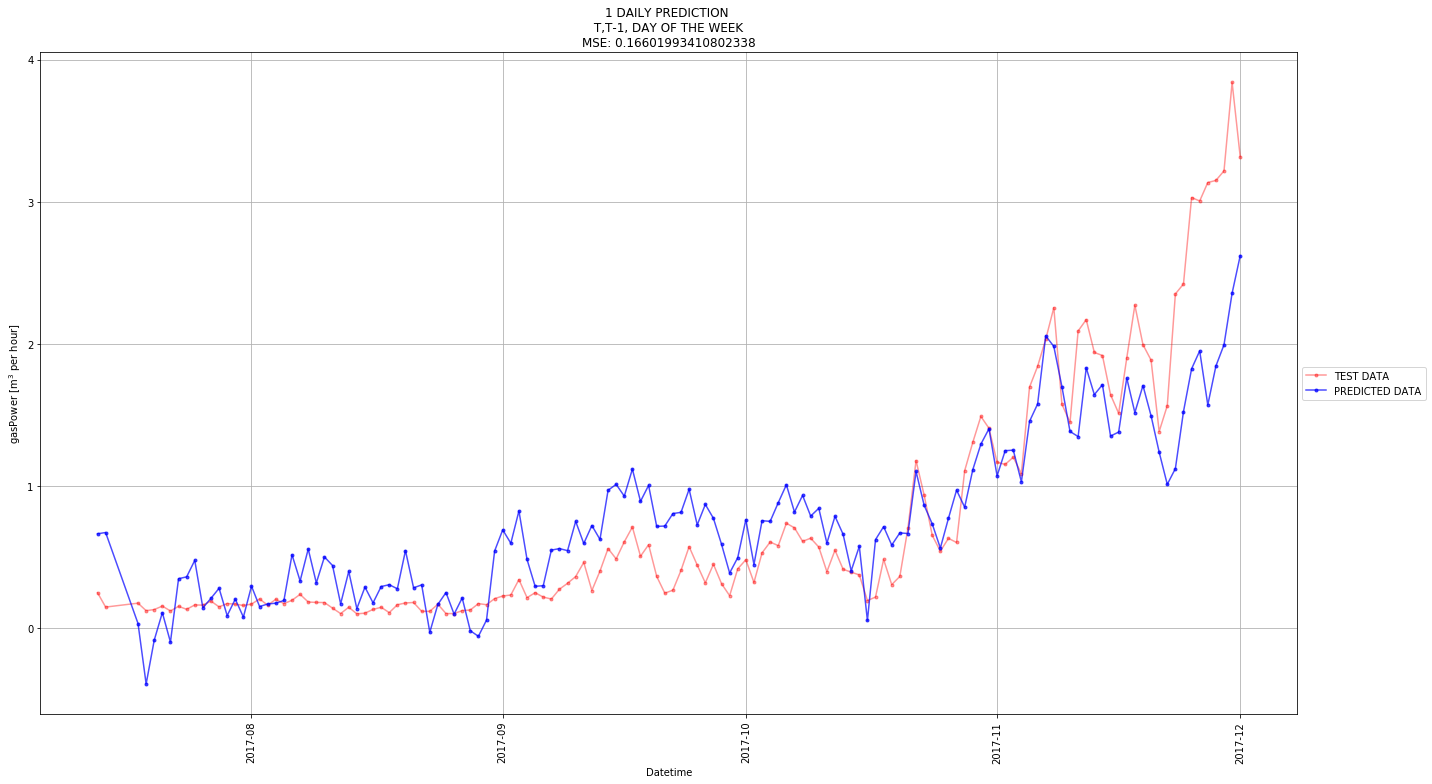

<Figure size 432x288 with 0 Axes>

In [26]:
MVR(df,X_MVR,y,0.5)

plt.savefig('MVR result daily[T,T-1,dayofweek].png', dpi=1200)

# Creating DNN

In [ ]:
#creating LR function (a = wx + b)

#lowering data to speed up the process
#x_data = x_data[0:100]
#y_data = y_data[0:100]
#choosing the model
model = Sequential()
#setting "one layer" (because just single variable)
model.add(Dense(1, input_dim=1, kernel_initializer='normal',activation='linear'))
#creating the gradient descent code
model.compile(loss='mean_squared_logarithmic_error', optimizer='rmsprop',metrics=['mse'])


In [ ]:
#looking at summarization of the model I created
model.summary()

In [ ]:
#displaying the model structure in a different way

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model,show_shapes=True).create(prog='dot',format='svg'))
"""displaying model structure does not work since modules are not installed on the server"""

In [ ]:
hist = model.fit(x_data,y_data,batch_size=1,epochs=100,shuffle=False)